In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
#Imported the data

data_download = pd.read_csv('mbti_1.csv')

In [3]:
data = data_download.copy()

In [4]:
pd.options.display.max_colwidth = 30
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/wa...
1,ENTP,'I'm finding the lack of m...
2,INTP,'Good one _____ https:/...
3,INTJ,"'Dear INTP, I enjoyed ou..."
4,ENTJ,'You're fired.|||That's an...


In [5]:
data.shape

(8675, 2)

In [6]:
data.dtypes

type     object
posts    object
dtype: object

### Looking at the counts of the different personality classifications, there are definitely some classications that are more populated than others. 

In [7]:
data.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

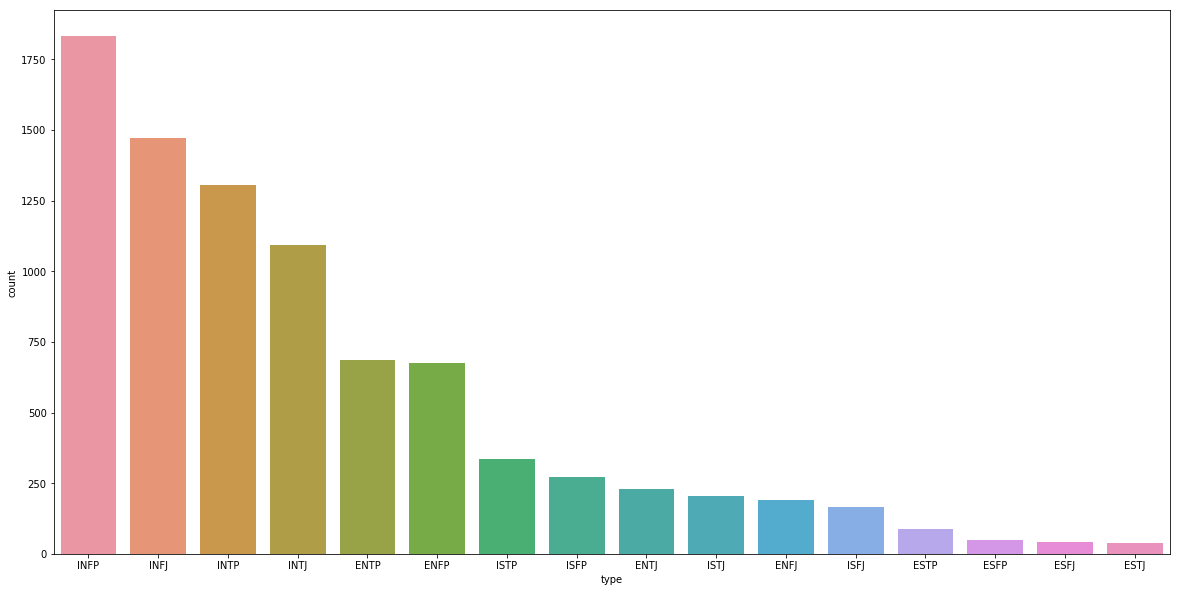

In [8]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.countplot(x="type", data=data, order = data.type.value_counts().index)
plt.show()

### With 50 posts per participant, the text samples are fairly long. 

### I see that I'll have to get rid of the ||| separators and a few embedded links.

### I see too that the writer mentions their personality classification. In this case, 'ENTP'. I may remove that since I would like to create a model that can predict the personality classification of people who are not aware of their classifications as these people are.  

### I will also do the following:

### 1. punctuation removal (and other random symbols)
### 2. lowercase
### 3. stop word removal
### 4. remove digits

In [9]:
pd.options.display.max_colwidth = 300000
print(data.loc[1,['posts']])

posts    'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/60

### Doing a quick check for missing data...

In [10]:
data.count()

type     8675
posts    8675
dtype: int64

### Removing URL

In [11]:
def remove_url(x):
    x = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', 'https', x)
    return x


In [12]:
data.posts = data.posts.apply(remove_url)

In [13]:
# print(data.loc[1,['posts']])

### Remove punctuation

In [13]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
punctuation_symbols = []
for each in list(punctuation):
    punctuation_symbols.append((each, ' '))

In [15]:
punctuation_symbols

[('!', ' '),
 ('"', ' '),
 ('#', ' '),
 ('$', ' '),
 ('%', ' '),
 ('&', ' '),
 ("'", ' '),
 ('(', ' '),
 (')', ' '),
 ('*', ' '),
 ('+', ' '),
 (',', ' '),
 ('-', ' '),
 ('.', ' '),
 ('/', ' '),
 (':', ' '),
 (';', ' '),
 ('<', ' '),
 ('=', ' '),
 ('>', ' '),
 ('?', ' '),
 ('@', ' '),
 ('[', ' '),
 ('\\', ' '),
 (']', ' '),
 ('^', ' '),
 ('_', ' '),
 ('`', ' '),
 ('{', ' '),
 ('|', ' '),
 ('}', ' '),
 ('~', ' ')]

In [16]:
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

In [17]:
data.posts = data.posts.apply(remove_puncuation)

In [19]:
# print(data.loc[1,['posts']])

### remove digits

In [18]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [19]:
data.posts = data.posts.apply(remove_digits)

In [22]:
# print(data.loc[1,['posts']])

### lower case and remove stop words

In [20]:
stop = stopwords.words('english')

In [21]:
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

In [22]:
data.posts = data.posts.apply(remove_stop_words)

In [26]:
# print(data.loc[1,['posts']])

In [23]:
def remove_extra_white_space(x):
    x = ' '.join(x.split())
    return x

In [24]:
data.posts = data.posts.apply(remove_extra_white_space)

In [25]:
def remove_types(x):
    x = re.sub(r'(i|e)(n|s)(t|f)(j|p)\w*', '', x)
    return x

In [ ]:
# (i|e)(n|s)(t|f)(j|p)\w*
# enfj\w*|enfp\w*|entj\w*|entp\w*|esfj\w*|esfp\w*|estj\w*|estp\w*|infp\w*|infj\w*|intj\w*|intp\w*|isfj\w*|isfp\w*|istj\w*|istp\w*

In [26]:
data.posts = data.posts.apply(remove_types)

In [27]:
print(data.loc[1,['posts']])

posts    finding lack posts alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello  grin takes converse flirting acknowledge presence return words smooth wordplay cheeky grins lack balance hand eye coordination real iq test score internet iq tests funny score higher like former responses thread mention believe iq test banish know  vanish site year half return find people still commenting posts liking ideas thoughts know  https think things sometimes go old sherlock holmes quote perhaps man special knowledge special powers like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real functions judge use use ne ti dominates fe emotions rarely si also use ni due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best makes lol guys lucky really high tumblr system hear

### Make countvectorizer- I will now make the countvectorizer using an example that I found from the meetup that I went to. It seems way easier than what I did before.

In [28]:
min_df = 0.01
max_df = 0.90
ngram_range = 2 # accounting for bi-grams

In [29]:
print('feature space will include words if they appear in a minimum of ', int(min_df*len(data)))
print('feature space will include words if they appear in a maxiumum of ', int(max_df*len(data)))

feature space will include words if they appear in a minimum of  86
feature space will include words if they appear in a maxiumum of  7807


In [30]:
# instantiate
countvec = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df, ngram_range=(0,2))

In [31]:
# fit and transform the item description
countvec_matrix = countvec.fit_transform(data.posts)

In [32]:
countvec.get_feature_names()

['abandoned',
 'abilities',
 'ability',
 'able',
 'able make',
 'abortion',
 'abroad',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absolutely love',
 'absorbed',
 'abstract',
 'absurd',
 'abuse',
 'abused',
 'abusive',
 'academic',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'accomplish',
 'accomplished',
 'according',
 'account',
 'accounts',
 'accuracy',
 'accurate',
 'accurately',
 'accused',
 'achieve',
 'acknowledge',
 'acquaintance',
 'acquaintances',
 'act',
 'act like',
 'acted',
 'acting',
 'acting like',
 'action',
 'actions',
 'active',
 'actively',
 'activities',
 'activity',
 'actor',
 'actors',
 'acts',
 'actual',
 'actually',
 'actually feel',
 'actually good',
 'actually know',
 'actually like',
 'actually pretty',
 'actually quite',
 'actually read',
 'actually really',
 'actually think',
 'actually thought',
 'actually want',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'addicted',
 

### Removing the personality type labels...

In [33]:
feature_matrix = pd.DataFrame(countvec_matrix.toarray(), columns=countvec.get_feature_names())

feature_matrix.head()

,abandoned,abilities,ability,able,able make,abortion,abroad,absence,absent,absolute,...,youngest,youre,youth,youtube,yup,zero,zodiac,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
feature_matrix.shape

(8675, 6495)

In [49]:
merged = pd.concat([data, feature_matrix], axis=1)
merged.shape

(8675, 6501)

In [50]:
merged.head()

,type,posts,type_IE,type_NS,type_TF,type_JP,abandoned,abilities,ability,able,...,youngest,youre,youth,youtube,yup,zero,zodiac,zombie,zombies,zone
0,INFJ,https moments https sportscenter top ten plays https pranks life changing experience life https https repeat today may perc experience immerse last thing friend posted facebook committing suicide next day rest peace https sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth https https welcome stuff https game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear favorite video games growing current favorite video games cool https appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo ladies complimentary personality well hey main social outlet xbox live conversations even verbally fatigue quickly https really dig part https thread requires get high backyard roast eat marshmellows backyard conversing something intellectual followed massages kisses https many b sentence could think b banned watching movies corner dunces banned health class clearly taught nothing peer pressure banned whole host reasons https two baby deer left right munching beetle middle using blood two cavemen diary today latest happenings designated cave diary wall see pokemon world society everyone becomes optimist https artists artists draw idea counts forming something like signature welcome robot ranks person downed self esteem cuz avid signature artist like proud banned taking room bed ya gotta learn share roaches https much thundering grumbling kind storm yep ahh old high school music heard ages https failed public speaking class years ago sort learned could better position big part failure overloading like person mentality confirmed way https denver area start new life,I,N,F,J,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENTP,finding lack posts alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello grin takes converse flirting acknowledge presence return words smooth wordplay cheeky grins lack balance hand eye coordination real iq test score internet iq tests funny score higher like former responses thread mention believe iq test banish know vanish site year half return find people still commenting posts liking ideas thoughts know https think things sometimes go old sherlock holmes quote perhaps man special knowledge special powers like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real functions judge use use ne ti dominates fe emotions rarely si also use ni due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best makes lol guys lucky really high tumblr system hear new first person shooter game rocking hell soundtrack auto sound equipment shake heavens managed put couple ps way connected things ne ne dominates aware environments se dominates example shawn spencer patrick jane well charlie first admit get jealous like chalk w heart mixed dominate w like noticed like known upload clip mic away mouth hear anything ninja assassin style splatter tik tok really great song long mental block singer love beat makes bounce drop io vswck mic really close mouth smokin aces assassins ball playing background sociable extrovert extrovert sociable sherlock movie normally played extj books said movie looked good except called sherlock holmes https never fear kissing guy kiss 

### Now to test some predictive models!!!

In [34]:
X = feature_matrix
Y = data['type']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 


Random Forest Classifier:
Training set score: 0.990931447894
Test set score: 0.216689718764


In [80]:
scores = cross_val_score(rfc, X, Y, cv=5)
scores  

array([ 0.21883975,  0.2199194 ,  0.21280277,  0.22215811,  0.2150289 ])

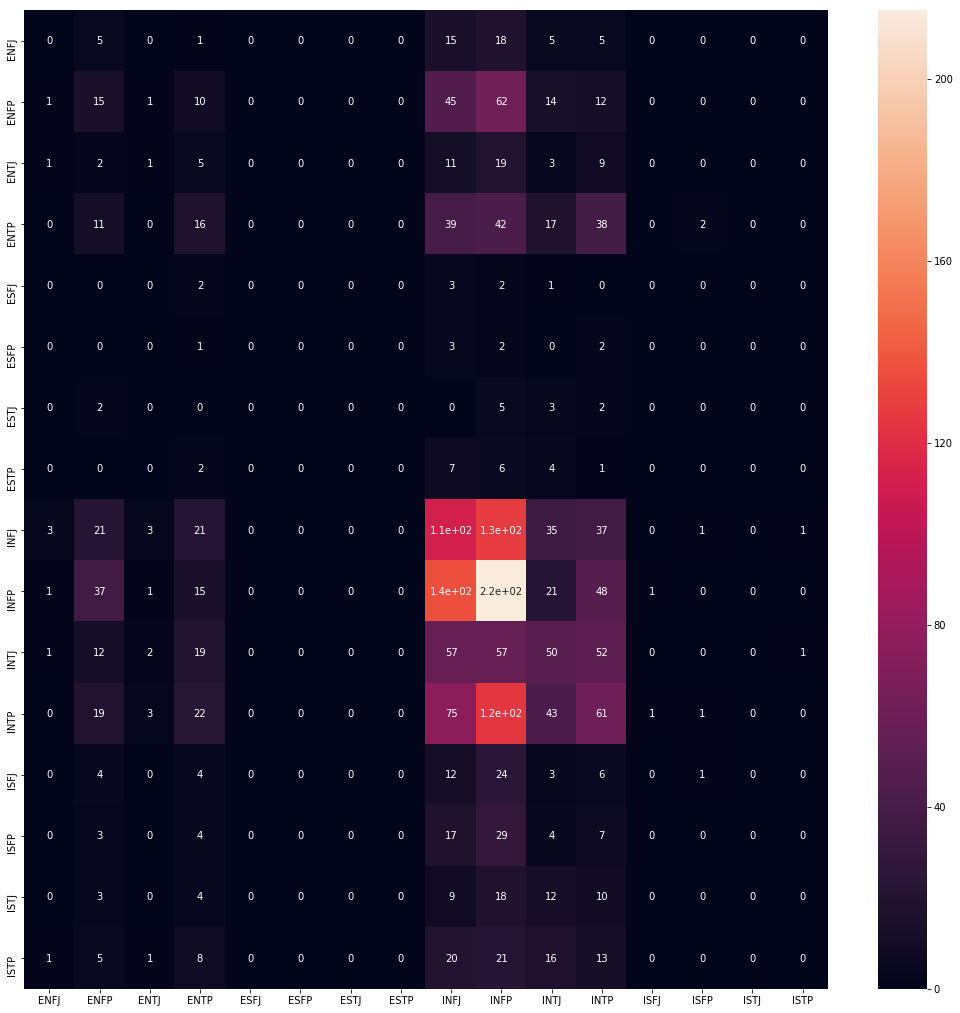

In [35]:
personality_types = sorted(data.type.unique())

Y_pred = rfc.predict(X_test)

confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])
plt.figure(figsize = (18,18))
sns.heatmap(df_cm, annot=True)
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=personality_types))

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00        49
       ENFP       0.11      0.09      0.10       160
       ENTJ       0.08      0.02      0.03        51
       ENTP       0.12      0.10      0.11       165
       ESFJ       0.00      0.00      0.00         8
       ESFP       0.00      0.00      0.00         8
       ESTJ       0.00      0.00      0.00        12
       ESTP       0.00      0.00      0.00        20
       INFJ       0.20      0.31      0.24       361
       INFP       0.28      0.45      0.34       475
       INTJ       0.22      0.20      0.21       251
       INTP       0.20      0.17      0.19       350
       ISFJ       0.00      0.00      0.00        54
       ISFP       0.00      0.00      0.00        64
       ISTJ       0.00      0.00      0.00        56
       ISTP       0.00      0.00      0.00        85

avg / total       0.17      0.22      0.19      2169



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### I did put the data through a Gradient Boosting Classifier and a Support Vector Machine Classifier. 

### The Gradient Boosting took far too long, so I stopped it before it could finish. 

### The Support Vector Machine took about 15 minutes and yielded results similiar to the logistic regression model. 

### So from here on out, I will be using random forest and logistic regression models.

In [39]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))

# clf = ensemble.GradientBoostingClassifier()
# clf.fit(X_train, Y_train)

# print('\nGradient Boosting Classifier:')
# print('Training set score:', clf.score(X_train, Y_train))
# print('Test set score:', clf.score(X_test, Y_test))

# svm = SVC(kernel = 'linear')
# svm.fit(X_train, Y_train)

# print('\nSupport Vector Machine:')
# print('Training set score:', svm.score(X_train, Y_train))
# print('Training set score:', svm.score(X_test, Y_test))



Logistic Regression:
Training set score: 0.999846295727
Test set score: 0.336099585062


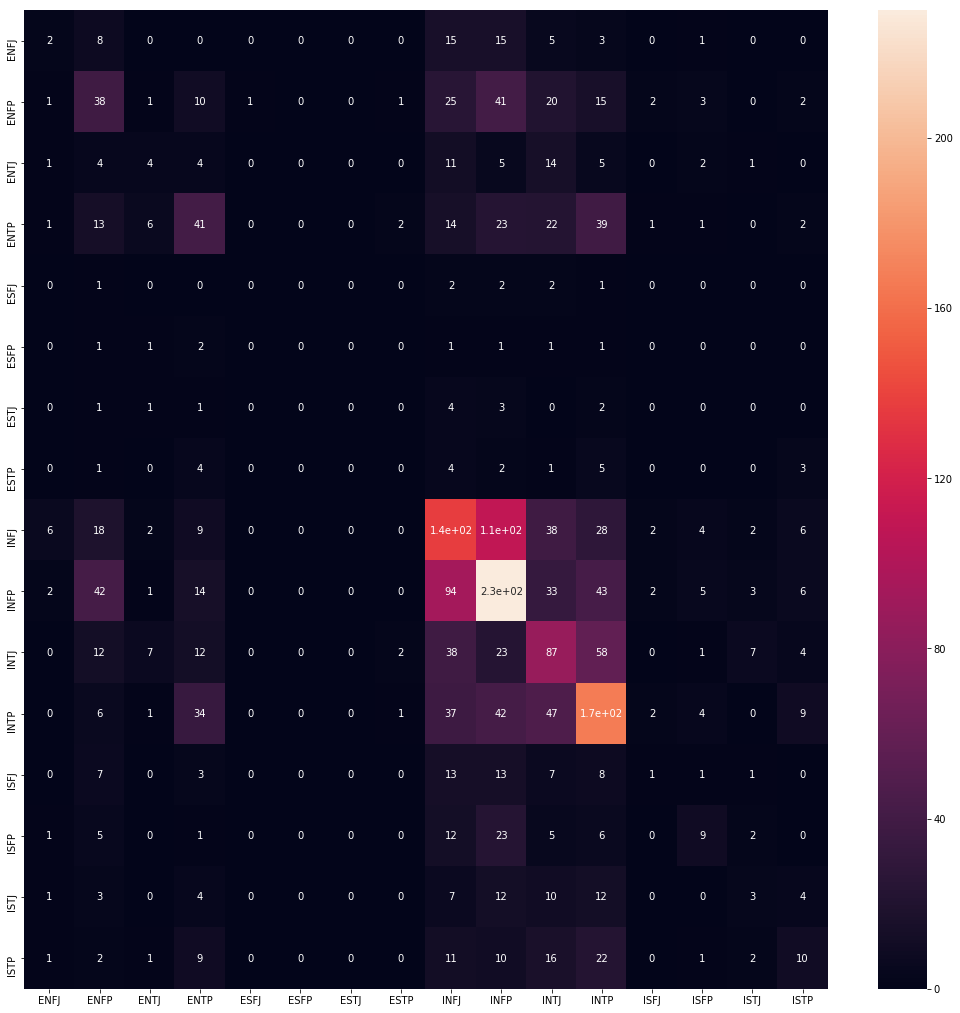

In [40]:
Y_pred = lr.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (18,18))
sns.heatmap(df_cm, annot=True)
plt.show()

In [41]:
print(classification_report(Y_test, Y_pred, target_names=personality_types))

             precision    recall  f1-score   support

       ENFJ       0.12      0.04      0.06        49
       ENFP       0.23      0.24      0.24       160
       ENTJ       0.16      0.08      0.11        51
       ENTP       0.28      0.25      0.26       165
       ESFJ       0.00      0.00      0.00         8
       ESFP       0.00      0.00      0.00         8
       ESTJ       0.00      0.00      0.00        12
       ESTP       0.00      0.00      0.00        20
       INFJ       0.32      0.38      0.35       361
       INFP       0.42      0.48      0.45       475
       INTJ       0.28      0.35      0.31       251
       INTP       0.40      0.48      0.44       350
       ISFJ       0.10      0.02      0.03        54
       ISFP       0.28      0.14      0.19        64
       ISTJ       0.14      0.05      0.08        56
       ISTP       0.22      0.12      0.15        85

avg / total       0.31      0.34      0.32      2169



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
data['type_IE'] = [x[0] for x in data.type]
data['type_NS'] = [x[1] for x in data.type]
data['type_TF'] = [x[2] for x in data.type]
data['type_JP'] = [x[3] for x in data.type]

In [43]:
print(data.type_IE.value_counts(), '\n')
print(data.type_NS.value_counts(), '\n')
print(data.type_TF.value_counts(), '\n')
print(data.type_JP.value_counts(), '\n')

I    6676
E    1999
Name: type_IE, dtype: int64 

N    7478
S    1197
Name: type_NS, dtype: int64 

F    4694
T    3981
Name: type_TF, dtype: int64 

P    5241
J    3434
Name: type_JP, dtype: int64 



In [56]:
data_I = merged.loc[data['type_IE'] == 'I'].sample(n=1999)
print(data_I.shape)
data_E = merged.loc[data['type_IE'] == 'E']
print(data_E.shape)
data_IE = pd.concat([data_I, data_E])
print(data_IE.shape)

(1999, 6501)
(1999, 6501)
(3998, 6501)


In [57]:
data_IE.columns

Index(['type', 'posts', 'type_IE', 'type_NS', 'type_TF', 'type_JP',
       'abandoned', 'abilities', 'ability', 'able',
       ...
       'youngest', 'youre', 'youth', 'youtube', 'yup', 'zero', 'zodiac',
       'zombie', 'zombies', 'zone'],
      dtype='object', length=6501)

In [61]:
drop_list = ['type','posts','type_IE','type_NS',"type_TF",'type_JP']
test = data_IE.drop(drop_list, axis=1).shape

In [63]:
test

(3998, 6493)

In [54]:
Y = data_IE['type_IE']
X = data_IE.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))

print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.991327551701

Cross Validation Scores:
 [ 0.53875     0.5725      0.55625     0.57625     0.55889724]

Logistic Regression:
Training set score: 1.0

Cross Validation Scores:
 [ 0.6375      0.635       0.64125     0.65        0.64912281]


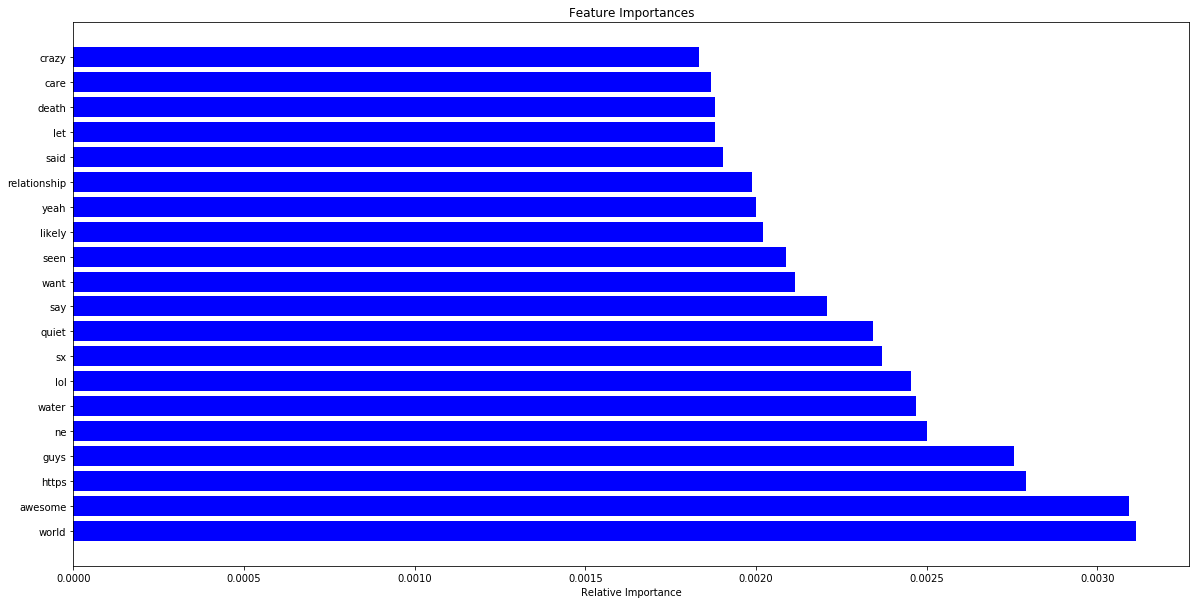

In [55]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [66]:
data_N = merged.loc[data['type_NS'] == 'N'].sample(n=1197)
print(data_I.shape)
data_S = merged.loc[data['type_NS'] == 'S']
print(data_E.shape)
data_NS = pd.concat([data_N, data_S])
print(data_NS.shape)

(1999, 6501)
(1999, 6501)
(2394, 6501)


In [67]:
Y = data_NS['type_NS']
X = data_NS.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))


Random Forest Classifier:
Training set score: 0.987186629526

Cross Validation Scores:
 [ 0.55416667  0.52708333  0.57322176  0.57322176  0.53556485]

Logistic Regression:
Training set score: 0.999442896936

Cross Validation Scores:
 [ 0.63333333  0.61875     0.64644351  0.64016736  0.66317992]


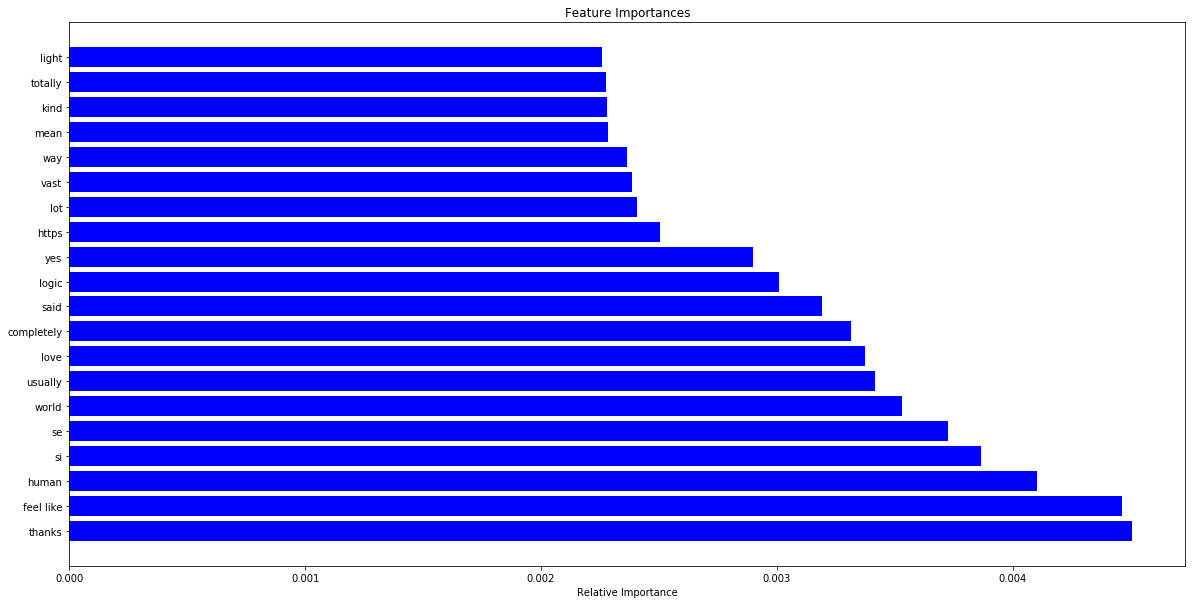

In [68]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [70]:
Y = data['type_TF']
X = feature_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  



lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.988933292346

Cross Validation Scores:
 [ 0.62672811  0.64841499  0.62478386  0.63631124  0.63379469]

Logistic Regression:
Training set score: 0.999846295727

Cross Validation Scores:
 [ 0.76036866  0.74293948  0.74351585  0.73717579  0.74106113]


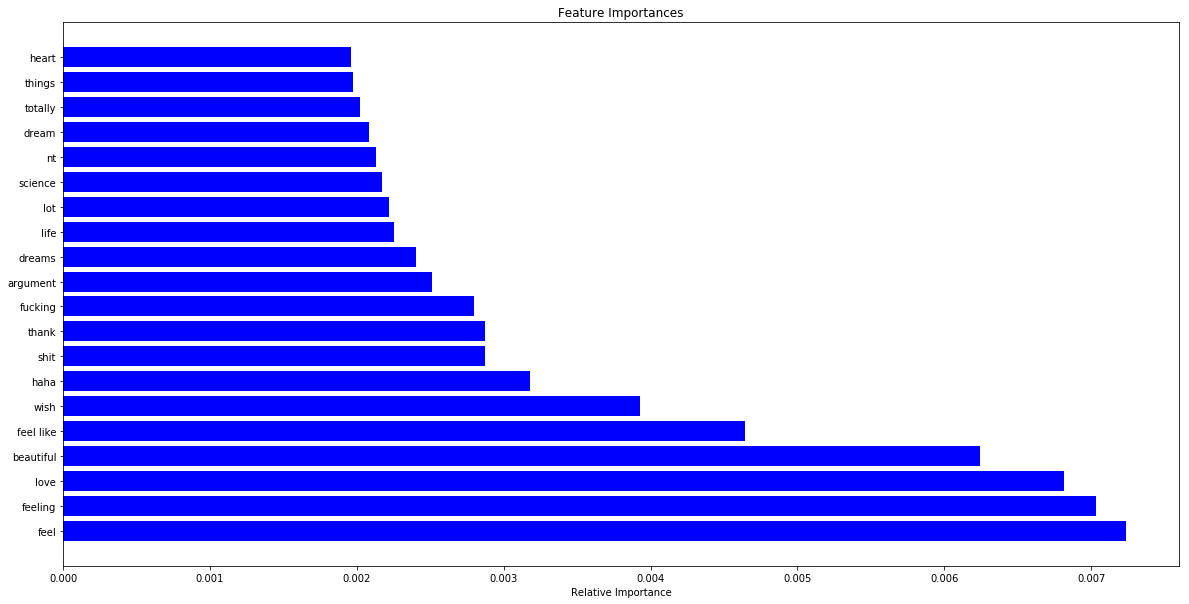

In [95]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

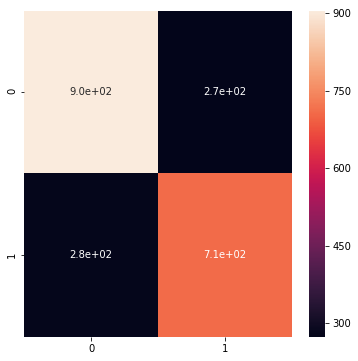

In [71]:
Y_pred = lr.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array)

plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True)
plt.show()

In [72]:
print(classification_report(Y_test, Y_pred, target_names=['T','F']))

             precision    recall  f1-score   support

          T       0.76      0.77      0.77      1179
          F       0.72      0.72      0.72       990

avg / total       0.74      0.74      0.74      2169



In [96]:
Y = data['type_JP']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))   

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.992468490624

Cross Validation Scores:
 [ 0.55299539  0.57636888  0.56195965  0.54927954  0.55478662]

Logistic Regression:
Training set score: 1.0

Cross Validation Scores:
 [ 0.63709677  0.63285303  0.65302594  0.59769452  0.61245675]


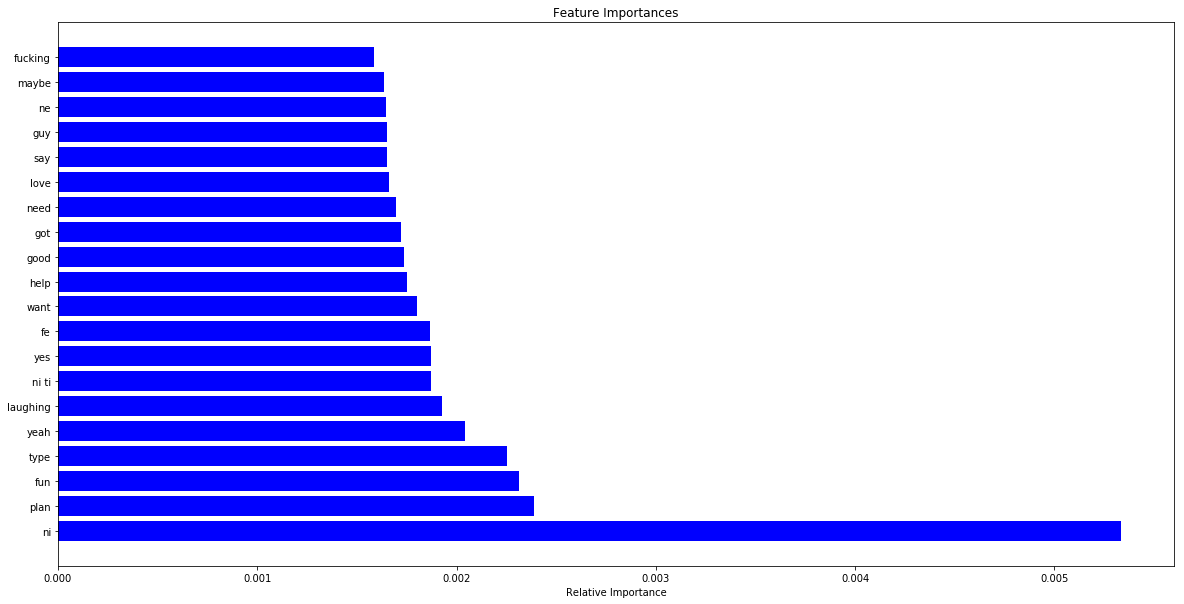

In [97]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

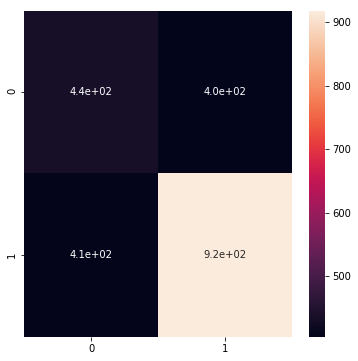

In [103]:
Y_pred = lr.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array)

plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True)
plt.show()

### Going to do a predictive model based off of the first 2 types... It ended up being in the 64-69 range...

In [54]:
data['type_first2'] = [x[0:2] for x in data.type]

In [55]:
Y = data['type_first2']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))   

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.983246234245

Cross Validation Scores:
 [ 0.65860679  0.65437788  0.65763689  0.65916955  0.66358915]

Logistic Regression:
Training set score: 0.999846295727

Cross Validation Scores:
 [ 0.69545193  0.67396313  0.69682997  0.66955017  0.6762839 ]


### I'm curious as to why Introvert vs Extrovert and Intuitive vs Observant are stronger indicators. I'm going to see which words show up the most for each group... 

In [98]:
feature_matrix_E = feature_matrix.copy()
feature_matrix_E['type_IE']= data.type_IE 
feature_matrix_E = feature_matrix_E.loc[feature_matrix_E.type_IE == 'E']

answers = feature_matrix_E[list(feature_matrix_E.columns)].sum()
answers = answers.to_frame()
answers = answers.drop(['type_IE'])
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 3150.0,
  'feel': 4935.0,
  'friends': 3252.0,
  'going': 2960.0,
  'good': 4854.0,
  'life': 3315.0,
  'lot': 3837.0,
  'love': 5323.0,
  'make': 3815.0,
  'person': 2878.0,
  'pretty': 2976.0,
  'right': 2991.0,
  'say': 4770.0,
  'sure': 3117.0,
  'thing': 3453.0,
  'things': 4635.0,
  'type': 4368.0,
  'want': 4392.0,
  'way': 4538.0,
  'yes': 2913.0}}

In [99]:
answers = feature_matrix_E[list(feature_matrix_E.columns)].mean()
answers = answers.to_frame()
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 1.5757878939469734,
  'feel': 2.468734367183592,
  'friends': 1.6268134067033517,
  'going': 1.4807403701850925,
  'good': 2.4282141070535266,
  'life': 1.6583291645822911,
  'lot': 1.9194597298649325,
  'love': 2.6628314157078541,
  'make': 1.9084542271135567,
  'person': 1.439719859929965,
  'pretty': 1.4887443721860931,
  'right': 1.4962481240620311,
  'say': 2.3861930965482743,
  'sure': 1.55927963981991,
  'thing': 1.7273636818409204,
  'things': 2.3186593296648326,
  'type': 2.1850925462731365,
  'want': 2.1970985492746373,
  'way': 2.2701350675337668,
  'yes': 1.4572286143071536}}

In [58]:
feature_matrix_E.shape

(1999, 6550)

In [59]:
feature_matrix_I = feature_matrix.copy()
feature_matrix_I['type_IE']= data.type_IE 
feature_matrix_I = feature_matrix_I.loc[feature_matrix_I.type_IE == 'I']

answers = feature_matrix_I[list(feature_matrix_I.columns)].sum()
answers = answers.to_frame()
answers = answers.drop(['type_IE'])
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 10063.0,
  'feel': 18402.0,
  'friends': 8912.0,
  'going': 9751.0,
  'good': 15867.0,
  'life': 12078.0,
  'lot': 12603.0,
  'love': 15770.0,
  'make': 12058.0,
  'person': 9930.0,
  'pretty': 9366.0,
  'right': 9722.0,
  'say': 15497.0,
  'sure': 9515.0,
  'thing': 10701.0,
  'things': 15852.0,
  'type': 12789.0,
  'want': 14986.0,
  'way': 15115.0,
  'yes': 9364.0}}

In [60]:
answers = feature_matrix_I[list(feature_matrix_I.columns)].mean()
answers = answers.to_frame()
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 1.5073397243858597,
  'feel': 2.7564409826243259,
  'friends': 1.334931096464949,
  'going': 1.4606051527860995,
  'good': 2.376722588376273,
  'life': 1.8091671659676454,
  'lot': 1.8878070701018574,
  'love': 2.3621929298981428,
  'make': 1.8061713600958658,
  'person': 1.4874176153385261,
  'pretty': 1.402935889754344,
  'right': 1.4562612342720191,
  'say': 2.3213001797483521,
  'sure': 1.4252546434991014,
  'thing': 1.6029059316956262,
  'things': 2.3744757339724387,
  'type': 1.9156680647094069,
  'want': 2.2447573397243858,
  'way': 2.2640802875973636,
  'yes': 1.4026363091671659}}

In [61]:
feature_matrix_I.shape

(6676, 6550)

In [62]:
feature_matrix_N = feature_matrix.copy()
feature_matrix_N['type_NS']= data.type_NS 
feature_matrix_N = feature_matrix_N.loc[feature_matrix_N.type_NS == 'N']

answers = feature_matrix_N[list(feature_matrix_N.columns)].mean()
answers = answers.to_frame()
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 1.5437282695907997,
  'feel': 2.7508692163680126,
  'friends': 1.3971650173843273,
  'going': 1.4592136935009361,
  'good': 2.3866006953730943,
  'life': 1.8078363198716234,
  'lot': 1.8983685477400374,
  'love': 2.4803423375234019,
  'make': 1.8492912543460818,
  'person': 1.4925113666755816,
  'pretty': 1.3882054025140411,
  'right': 1.4780690024070606,
  'say': 2.3396630115004013,
  'sure': 1.439823482214496,
  'thing': 1.6428189355442633,
  'things': 2.3526343942230543,
  'type': 1.9208344477132924,
  'want': 2.2408397967370957,
  'way': 2.2939288579834178,
  'yes': 1.4458411339930464}}

In [63]:
feature_matrix_S = feature_matrix.copy()
feature_matrix_S['type_NS']= data.type_NS 
feature_matrix_S = feature_matrix_S.loc[feature_matrix_S.type_NS == 'S']

answers = feature_matrix_S[list(feature_matrix_S.columns)].mean()
answers = answers.to_frame()
answers[[0]] = answers[[0]].astype(float)
answers = answers.nlargest(20, 0, keep ='first')
answers = answers.to_dict()
answers

{0: {'actually': 1.3943191311612364,
  'feel': 2.3107769423558899,
  'friends': 1.4335839598997493,
  'going': 1.5029239766081872,
  'good': 2.4010025062656641,
  'life': 1.5655806182121972,
  'lot': 1.8746867167919798,
  'love': 2.1261487050960737,
  'make': 1.7076023391812865,
  'person': 1.3759398496240602,
  'pretty': 1.6382623224728488,
  'right': 1.3868003341687551,
  'say': 2.3149540517961569,
  'sure': 1.5580618212197159,
  'thing': 1.5614035087719298,
  'things': 2.4177109440267337,
  'type': 2.3333333333333335,
  'want': 2.1896407685881369,
  'way': 2.0877192982456139,
  'work': 1.3943191311612364}}

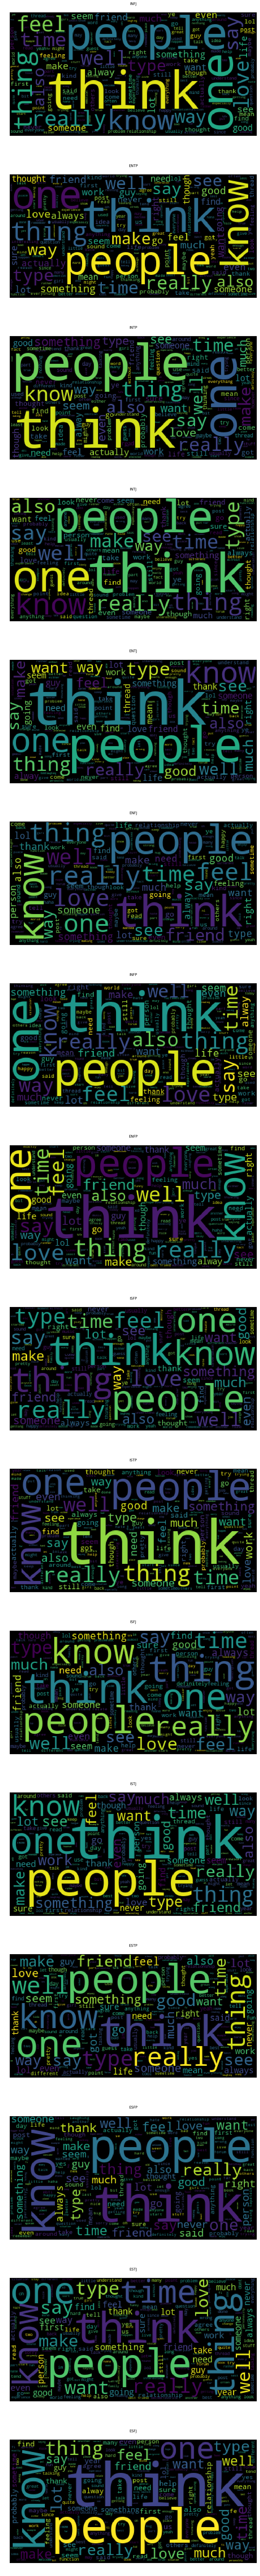

In [100]:
from scipy.misc.pilutil import imread
# from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(data['type'].unique()), sharex=True, figsize=(15,10*len(data['type'].unique())))

k = 0
for i in data['type'].unique():
    df_4 = data[data['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1
plt.show()

In [72]:
data.head()

,type,posts,type_IE,type_NS,type_TF,type_JP,type_first2
0,INFJ,intj moments sportscenter top ten plays pranks life changing experience life repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace enfj sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth welcome stuff game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video games growing current favorite video games cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo entp ladies complimentary personality well hey main social outlet xbox live conversations even verbally fatigue quickly really dig part thread requires get high backyard roast eat marshmellows backyard conversing something intellectual followed massages kisses many b sentence could think b banned watching movies corner dunces banned health class clearly taught nothing peer pressure banned whole host reasons two baby deer left right munching beetle middle using blood two cavemen diary today latest happenings designated cave diary wall see pokemon world infj society everyone becomes optimist artists artists draw idea counts forming something like signature welcome robot ranks person downed self esteem cuz avid signature artist like proud banned taking room bed ya gotta learn share roaches much thundering grumbling kind storm yep ahh old high school music heard ages failed public speaking class years ago sort learned could better position big part failure overloading like person mentality confirmed intj way denver area start new life,I,N,F,J,IN
1,ENTP,finding lack posts alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello entp grin takes converse flirting acknowledge presence return words smooth wordplay cheeky grins lack balance hand eye coordination real iq test score internet iq tests funny score higher like former responses thread mention believe iq test banish know entp vanish site year half return find people still commenting posts liking ideas thoughts know entp think things sometimes go old sherlock holmes quote perhaps man special knowledge special powers like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real functions judge use use ne ti dominates fe emotions rarely si also use ni due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best makes lol guys lucky really high tumblr system hear new first person shooter game rocking hell soundtrack auto sound equipment shake heavens managed put couple ps way connected things ne ne dominates aware environments se dominates example shawn spencer patrick jane entps well charlie first admit get jealous like chalk w heart mixed dominate w like noticed like known upload clip mic away mouth hear anything ninja assassin style splatter tik tok really great song long mental block singer love beat makes bounce drop io vswck mic really close mouth smokin aces assassins ball playing background sociable extrovert extrovert sociable sherlock movie entp normally played extj books estj said movie looked good except called sherlock holmes never fear kissing guy kiss animal nothing vanish personal taste liking guy kissed know one sounds pretty much like area going right trying figure way want take life want many things biggest problem kn

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
# instantiate
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.1, max_df=0.98, stop_words = 'english', norm='l2')

In [123]:
# fit & transform
tfidf_matrix = tf.fit_transform(data.posts)

print('Number of documents:', tfidf_matrix.shape[0], ', number of features:', tfidf_matrix.shape[1])

Number of documents: 8675 , number of features: 753


In [107]:
tf.get_feature_names()

['actually',
 'best',
 'better',
 'come',
 'day',
 'different',
 'feel',
 'friend',
 'friends',
 'going',
 'good',
 'got',
 'hard',
 'kind',
 'know',
 'life',
 'little',
 'long',
 'look',
 'lot',
 'love',
 'make',
 'makes',
 'maybe',
 'mean',
 'mind',
 'need',
 'new',
 'person',
 'point',
 'post',
 'pretty',
 'probably',
 'read',
 'really',
 'right',
 'said',
 'say',
 'sure',
 'tell',
 'thing',
 'things',
 'thinking',
 'thought',
 'thread',
 'time',
 'try',
 'trying',
 'type',
 'understand',
 'usually',
 'want',
 'way',
 'work',
 'world',
 'years',
 'yes']

In [124]:
# examine the vocabulary and document-term matrix together
tfidf_feature_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
tfidf_feature_matrix.head()

,ability,able,absolutely,accept,accurate,act,action,actual,actually,add,...,wrote,xd,yeah,year,years,years ago,yes,yesterday,young,younger
0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.053716,0.097858,0.000000,0.0,0.0,0.0
1,0.00000,0.049264,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.045739,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.15751,0.054634,0.131651,0.0,0.078846,0.0,0.000000,0.000000,0.071841,0.0,...,0.0,0.000000,0.000000,0.050725,0.166760,0.000000,0.037494,0.0,0.0,0.0
3,0.00000,0.087892,0.000000,0.0,0.000000,0.0,0.068687,0.068034,0.057787,0.0,...,0.0,0.000000,0.036321,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.030388,0.0,...,0.0,0.068411,0.000000,0.042912,0.000000,0.000000,0.031719,0.0,0.0,0.0


In [125]:
tfidf_feature_matrix.shape

(8675, 753)

In [126]:
X = tfidf_feature_matrix
Y = data['type']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 


Random Forest Classifier:
Training set score: 0.994620350446
Test set score: 0.217611802674


In [127]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))


Logistic Regression:
Training set score: 0.493083307716
Test set score: 0.362378976487


In [128]:
Y = data['type_IE']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))

print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.991085152167

Cross Validation Scores:
 [ 0.73329493  0.73659942  0.73717579  0.73025937  0.73471742]

Logistic Regression:
Training set score: 0.7946510913

Cross Validation Scores:
 [ 0.78168203  0.77694524  0.78501441  0.77925072  0.77566321]


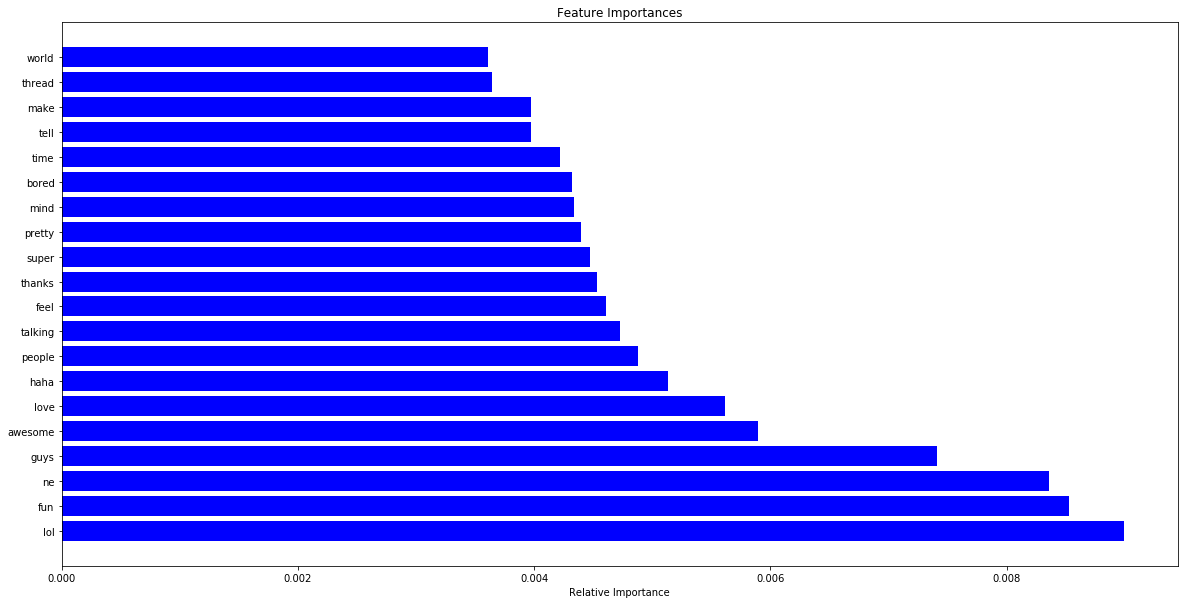

In [129]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [130]:
Y = data['type_NS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))


Random Forest Classifier:
Training set score: 0.977866584691

Cross Validation Scores:
 [ 0.86232719  0.86117512  0.85821326  0.85986159  0.85813149]

Logistic Regression:
Training set score: 0.866584691054

Cross Validation Scores:
 [ 0.86117512  0.86175115  0.86397695  0.8627451   0.8633218 ]


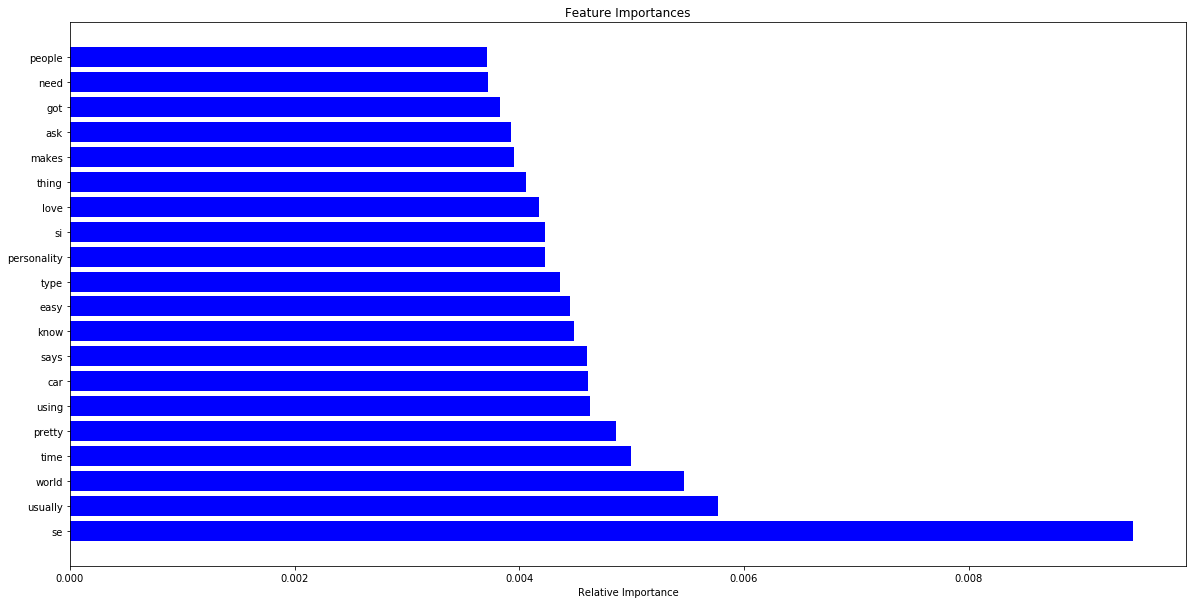

In [131]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [132]:
Y = data['type_TF']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))  



lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.990009222256

Cross Validation Scores:
 [ 0.63940092  0.64495677  0.62881844  0.64149856  0.62283737]

Logistic Regression:
Training set score: 0.813556716877

Cross Validation Scores:
 [ 0.78917051  0.76311239  0.76080692  0.75965418  0.7739331 ]


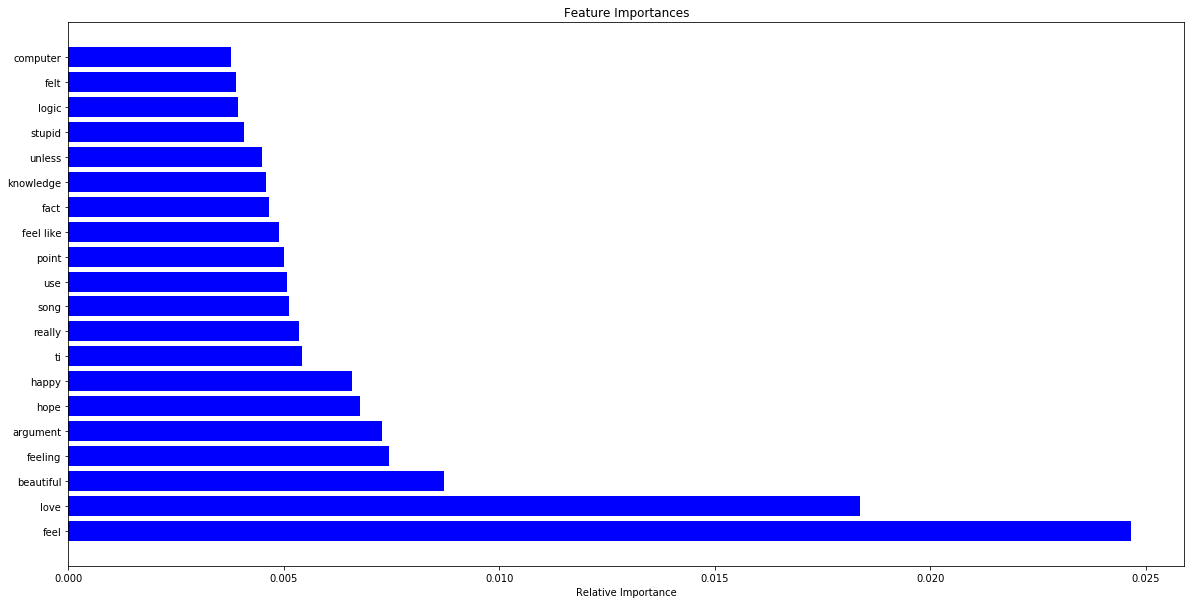

In [133]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [134]:
Y = data['type_JP']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc, X, Y, cv=5))   

lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr, X, Y, cv=5))  


Random Forest Classifier:
Training set score: 0.991085152167

Cross Validation Scores:
 [ 0.54435484  0.57752161  0.55216138  0.55158501  0.588812  ]

Logistic Regression:
Training set score: 0.722871195819

Cross Validation Scores:
 [ 0.66071429  0.66167147  0.67204611  0.65763689  0.66724337]


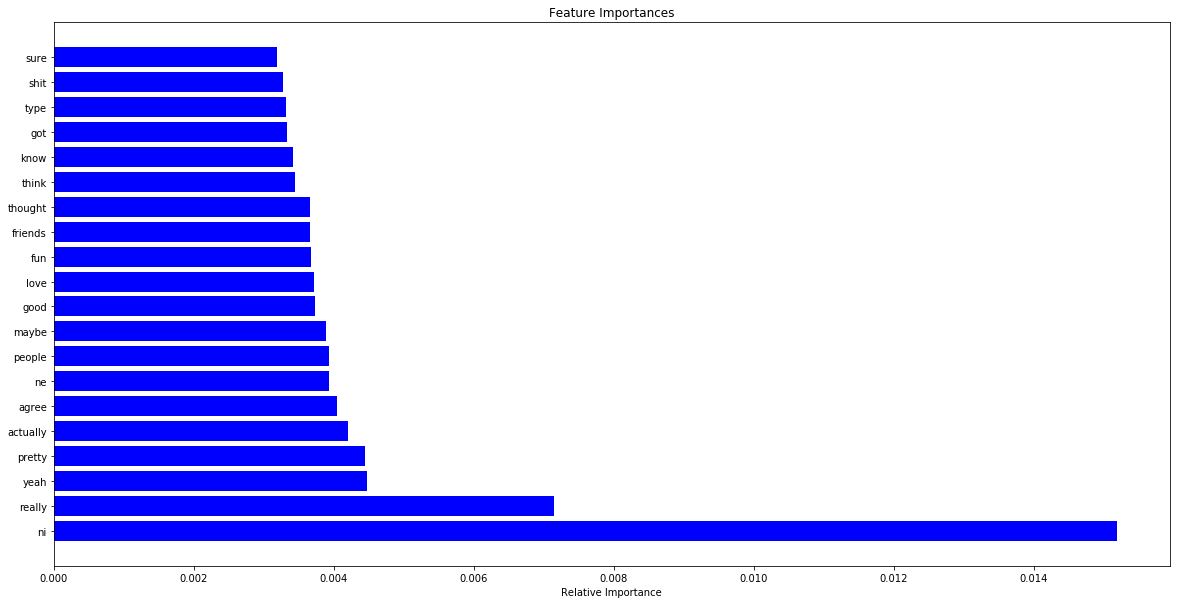

In [135]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()